In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm
import os
import gc
import scipy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.optimizers import Adam
import kerastuner as kt


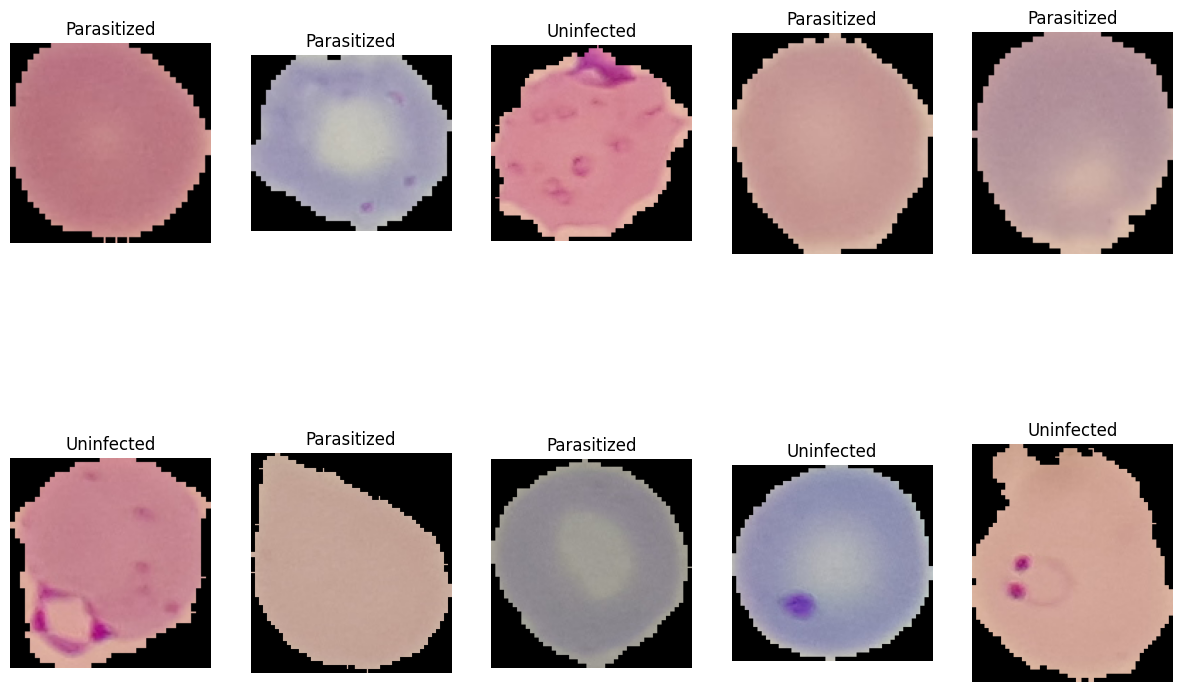

In [ ]:
# Load the dataset
dataset, info = tfds.load('malaria', with_info=True, as_supervised=True, split=['train[:10%]', 'train[10%:]'])
train_ds, _ = dataset

# Extract 5-10 images from the dataset
def extract_images(dataset, num_images=10):
    images = []
    labels = []
    for image, label in dataset.take(num_images):
        images.append(image.numpy())
        labels.append(label.numpy())
    return images, labels

images, labels = extract_images(train_ds, num_images=10)

# Display the images
def display_images(images, labels):
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title('Parasitized' if labels[i] == 1 else 'Uninfected')
        plt.axis('off')
    plt.show()

display_images(images, labels)


In [ ]:
train_ds, test_ds = dataset

In [ ]:
# Preprocessing functions
def preprocess_image(image, label, size=(128, 128)):
    image = tf.image.resize(image, size)
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

def one_hot_encode(label):
    return to_categorical(label, num_classes=2)

def preprocess_and_encode_image(image, label, size=(128, 128)):
    image, label = preprocess_image(image, label, size)
    label = one_hot_encode(label)
    return image, label

# Apply preprocessing
train_ds = train_ds.map(lambda img, lbl: preprocess_and_encode_image(img, lbl))
test_ds = test_ds.map(lambda img, lbl: preprocess_and_encode_image(img, lbl))

# Prepare data for training
BATCH_SIZE = 32
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

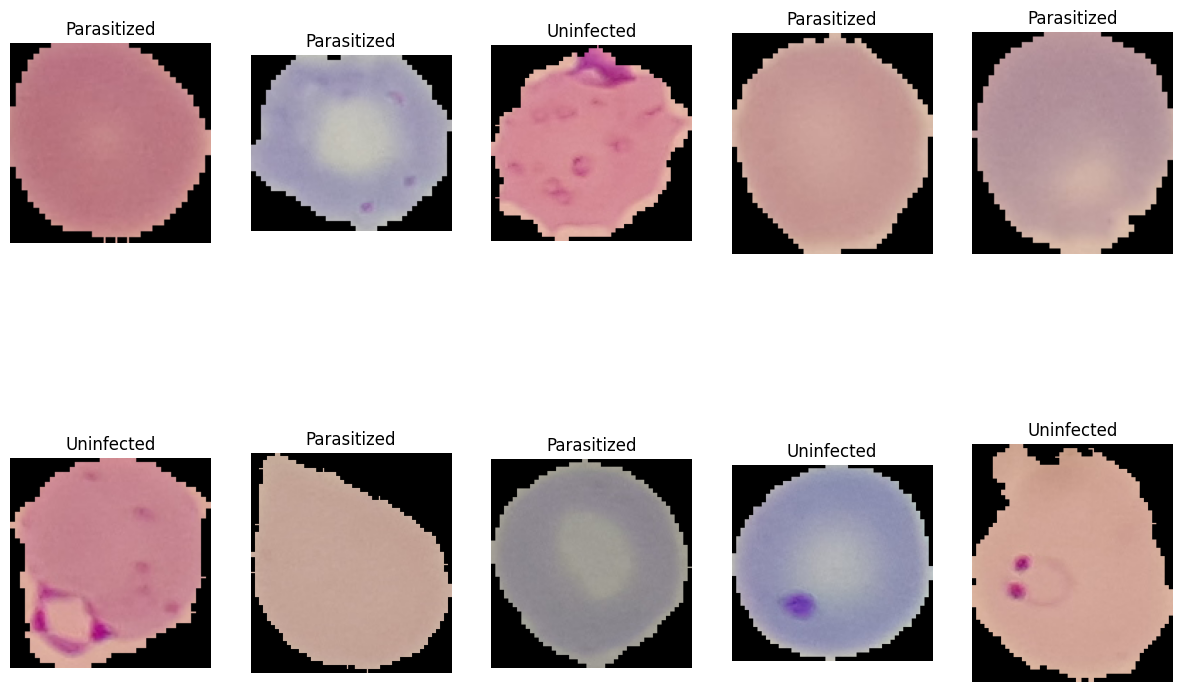

Number of training samples: 2756
Number of test samples: 24802


In [ ]:
# Get a small subset of images for visualization
num_samples = 10
images, labels = extract_images(train_ds, num_images=num_samples)

# Verify the dataset splits
print(f"Number of training samples: {len(list(train_ds))}")
print(f"Number of test samples: {len(list(test_ds))}")

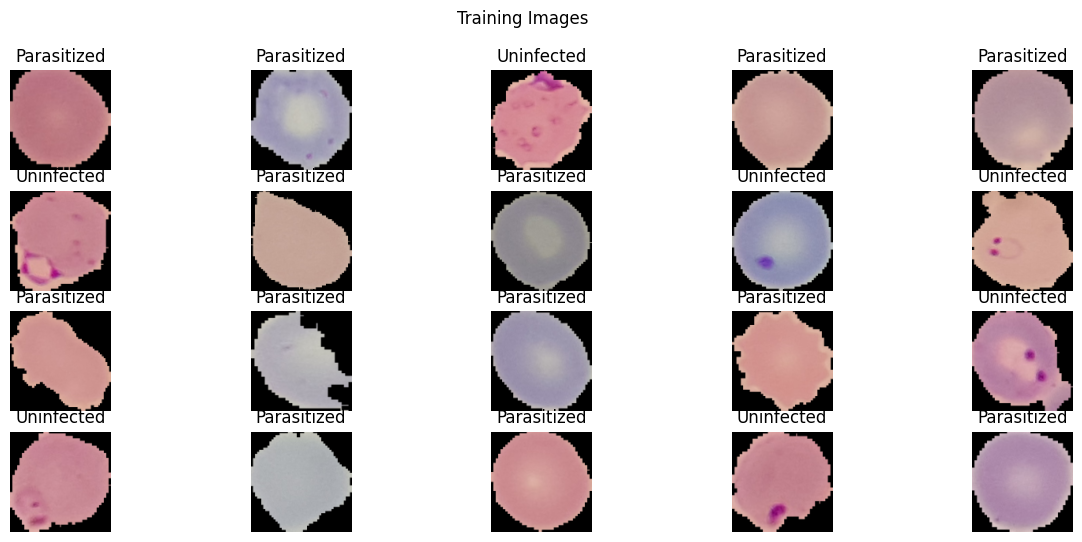

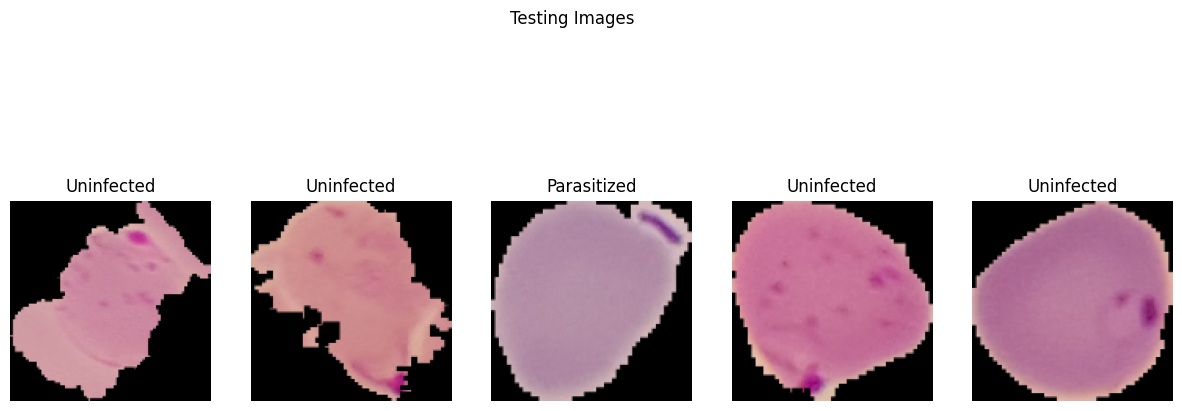

Number of training images displayed: 20
Number of testing images displayed: 5


In [ ]:


# Load the dataset
dataset, info = tfds.load('malaria', with_info=True, as_supervised=True, split=['train[:80%]', 'train[80%:]'])
train_ds, test_ds = dataset

# Define the image size and batch size
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 16

# Function to preprocess the images
def preprocess_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0  # Normalize the image
    return image, label

# Apply preprocessing to the datasets
train_ds = train_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Extract images for visualization
def extract_images(dataset, num_images=5):
    images = []
    labels = []
    for image_batch, label_batch in dataset.take(num_images // BATCH_SIZE + 1):
        images.extend(image_batch.numpy())
        labels.extend(label_batch.numpy())
        if len(images) >= num_images:
            break
    return images[:num_images], labels[:num_images]

# Get a subset of images for visualization
train_images, train_labels = extract_images(train_ds, num_images=20)
test_images, test_labels = extract_images(test_ds, num_images=5)

# Display images from a dataset
def display_images(images, labels, title):
    plt.figure(figsize=(15, 6))
    num_images = len(images)
    cols = 5
    rows = (num_images + cols - 1) // cols  # Calculate number of rows
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.title('Parasitized' if labels[i] == 1 else 'Uninfected')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display training images
display_images(train_images, train_labels, "Training Images")

# Display testing images
display_images(test_images, test_labels, "Testing Images")

# Verify the dataset splits
print(f"Number of training images displayed: {len(train_images)}")
print(f"Number of testing images displayed: {len(test_images)}")


In [ ]:
# Apply preprocessing to the datasets
train_ds = train_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Convert dataset to numpy arrays
def dataset_to_numpy(dataset, num_samples):
    images = []
    labels = []
    for image_batch, label_batch in dataset.take(num_samples // BATCH_SIZE + 1):
        images.extend(image_batch.numpy())
        labels.extend(label_batch.numpy())
        if len(images) >= num_samples:
            break
    return np.array(images[:num_samples]), np.array(labels[:num_samples])

# Extract a subset of images and labels
num_train_samples = 20  # Number of training samples
num_test_samples = 5    # Number of testing samples

X_train, Y_train = dataset_to_numpy(train_ds, num_samples=num_train_samples)
X_test, Y_test = dataset_to_numpy(test_ds, num_samples=num_test_samples)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# Convert labels to categorical
Y_train = to_categorical(Y_train, num_classes=2)
Y_test = to_categorical(Y_test, num_classes=2)

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_val.shape}")
print(f"Test data shape: {X_test.shape}")


Training data shape: (16, 16, 128, 128, 3)
Validation data shape: (4, 16, 128, 128, 3)
Test data shape: (5, 16, 128, 128, 3)


CNN Model

In [ ]:


# Define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(128, 128, 3)))  # Adjust input shape
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))  # Adjust pooling parameters
model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))
model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))  # 2 classes: Parasitized and Uninfected

# Compile the model
model.compile(
    loss='categorical_crossentropy',  # Use categorical_crossentropy for multi-class classification
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32768)               │         131,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │          65,538 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 289,858 (1.11 MB)

 Trainable params: 224,322 (876.26 KB)

 Non-trainable params: 65,536 (256.00 KB)

Model Execution

In [ ]:
# Example of loading and preparing data
def load_and_prepare_data():
    # This is a placeholder. Replace with actual data loading.
    # Here we assume x_train and y_train are loaded and shaped correctly.
    x_train = np.random.rand(256, 128, 128, 3)  # Replace with actual data
    y_train = np.random.randint(0, 2, size=(256,))  # Replace with actual labels

    # Convert labels to one-hot encoding
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)

    # Split into training and validation sets
    split_index = int(0.8 * len(x_train))
    x_val, y_val = x_train[split_index:], y_train[split_index:]
    x_train, y_train = x_train[:split_index], y_train[:split_index]

    return x_train, y_train, x_val, y_val

# Load and prepare data
x_train, y_train, x_val, y_val = load_and_prepare_data()

# Verify the shapes
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

# Check if x_train and y_train have the same number of samples
assert x_train.shape[0] == y_train.shape[0], "Mismatch between number of samples in x_train and y_train"
assert x_val.shape[0] == y_val.shape[0], "Mismatch between number of samples in x_val and y_val"

# Define ImageDataGenerator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    zoom_range=0.2,     # Randomly zoom in on images
    rotation_range=30,  # Randomly rotate images
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True    # Randomly flip images vertically
)

# Define ImageDataGenerator for validation (no data augmentation)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Normalize pixel values to [0, 1]

# Create generators for training and validation
train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=16
)

val_generator = val_datagen.flow(
    x_val, y_val,
    batch_size=16
)

# Define your CNN model
model = Sequential([
    Conv2D(16, (3, 3), padding="valid", activation="relu", input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
    Conv2D(32, (3, 3), padding="valid", activation="relu"),
    MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
    Conv2D(64, (3, 3), padding="valid", activation="relu"),
    MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
    Flatten(),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Train the model using the generators
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 16,
    epochs=4,
    validation_data=val_generator,
    validation_steps=len(x_val) // 16
)

# Print the training history
print("Training history:")
print(history.history)


x_train shape: (204, 128, 128, 3)
y_train shape: (204, 2)
x_val shape: (52, 128, 128, 3)
y_val shape: (52, 2)
Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 617ms/step - accuracy: 0.4240 - loss: 0.6961 - val_accuracy: 0.4583 - val_loss: 0.6949
Epoch 2/4
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5625 - loss: 0.6907

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.5625 - loss: 0.6907 - val_accuracy: 0.7500 - val_loss: 0.6806
Epoch 3/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.4970 - loss: 0.6954 - val_accuracy: 0.4792 - val_loss: 0.6966
Epoch 4/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5625 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6946
Training history:
{'accuracy': [0.43617022037506104, 0.5625, 0.5159574747085571, 0.5625], 'loss': [0.6953731179237366, 0.690655529499054, 0.6940487623214722, 0.6933399438858032], 'val_accuracy': [0.4583333432674408, 0.75, 0.4791666567325592, 0.5], 'val_loss': [0.694905698299408, 0.6805520057678223, 0.6966097354888916, 0.6945644617080688]}


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 126, 126, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 124, 124, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 122, 122, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 952576)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 952576)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 952576)              │       3,810,304 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │       1,905,154 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,406,824 (51.14 MB)

 Trainable params: 3,833,890 (14.63 MB)

 Non-trainable params: 1,905,152 (7.27 MB)

 Optimizer params: 7,667,782 (29.25 MB)

In [ ]:
pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


In [ ]:


# Define the CNN model
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), padding="valid", activation="relu", input_shape=(128, 128, 3)))  # Adjust input_shape to match the image size
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
model.add(layers.Conv2D(32, (3, 3), padding="valid", activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
model.add(layers.Conv2D(64, (3, 3), padding="valid", activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.BatchNormalization())  # Batch normalization for better training
model.add(layers.Dense(2, activation='softmax'))  # Output layer for 2 classes

# Compile the model
model.compile(
    loss=CategoricalCrossentropy(),  # Use CategoricalCrossentropy for multi-class classification
    optimizer=Adam(learning_rate=1e-4),  # Adam optimizer with learning rate of 1e-4
    metrics=['accuracy']  # Metrics to monitor
)




In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 126, 126, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 124, 124, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 122, 122, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 952576)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 952576)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 952576)              │       3,810,304 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │       1,905,154 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,739,042 (21.89 MB)

 Trainable params: 3,833,890 (14.63 MB)

 Non-trainable params: 1,905,152 (7.27 MB)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy

# Define the CNN model
model = Sequential()
model.add(Conv2D(16, (3, 3), padding="valid", activation="relu", input_shape=(128, 128, 3)))  # Adjust input_shape based on image size
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
model.add(Flatten())
model.add(Dropout(0.5))  # Dropout for regularization
model.add(BatchNormalization())  # Batch normalization for improved training
model.add(Dense(2, activation='softmax'))  # Output layer for 2 classes

# Compile the model
optimizer = RMSprop(learning_rate=0.001)  # RMSprop optimizer with learning rate of 0.001
model.compile(
    loss=CategoricalCrossentropy(),  # Use CategoricalCrossentropy for multi-class classification
    optimizer=optimizer,
    metrics=['accuracy']  # Metrics to monitor
)

# Summary of the model
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 126, 126, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 124, 124, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 122, 122, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 952576)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 952576)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 952576)              │       3,810,304 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │       1,905,154 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,739,042 (21.89 MB)

 Trainable params: 3,833,890 (14.63 MB)

 Non-trainable params: 1,905,152 (7.27 MB)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.losses import CategoricalCrossentropy

# Load the pre-trained ResNet50 model without the top layers
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))  # Adjust input_shape if necessary

# Freeze the weights of the pre-trained layers
for layer in resnet.layers:
    layer.trainable = False

# Create the top layers for classification
x = resnet.output
x = Flatten()(x)
x = Dropout(0.5)(x)  # Dropout to reduce overfitting
x = BatchNormalization()(x)  # Batch normalization to improve training stability
outputs = Dense(2, activation='softmax')(x)  # 2 classes for malaria (Parasitized and Uninfected)

# Create the complete model
model = Model(inputs=resnet.input, outputs=outputs)

# Compile the model
model.compile(
    loss=CategoricalCrossentropy(),  # Use CategoricalCrossentropy for multi-class classification
    optimizer=Adam(learning_rate=1e-4),  # Adam optimizer with a learning rate of 1e-4
    metrics=['accuracy']  # Metrics to monitor
)

# Summary of the model
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,784,322 (90.73 MB)

 Trainable params: 131,074 (512.01 KB)

 Non-trainable params: 23,653,248 (90.23 MB)

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.losses import CategoricalCrossentropy

# Load the pre-trained MobileNet model without the top layers
mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape=(128, 128, 3))  # Adjust input_shape if necessary

# Freeze the weights of the pre-trained layers
for layer in mobilenet.layers:
    layer.trainable = False

# Create the top layers for classification
x = mobilenet.output
x = GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling2D to reduce dimensions
x = Dropout(0.5)(x)  # Dropout to reduce overfitting
outputs = Dense(2, activation='softmax')(x)  # 2 classes for malaria (Parasitized and Uninfected)

# Create the complete model
model = Model(inputs=mobilenet.input, outputs=outputs)

# Compile the model
model.compile(
    loss=CategoricalCrossentropy(),  # Use CategoricalCrossentropy for multi-class classification
    optimizer=Adam(learning_rate=1e-4),  # Adam optimizer with a learning rate of 1e-4
    metrics=['accuracy']  # Metrics to monitor
)

# Summary of the model
model.summary()


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 64, 64, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 64, 64, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 64, 64, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 65, 65, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 32, 32, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 32, 32, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 32, 32, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 32, 32, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,230,914 (12.32 MB)

 Trainable params: 2,050 (8.01 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
import matplotlib.pyplot as plt

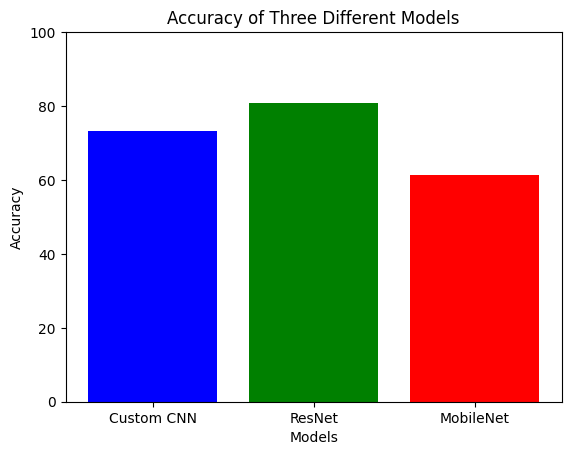

In [ ]:
# Step 2: Define model names and their accuracies
model_names = ['Custom CNN', 'ResNet', 'MobileNet']
accuracies = [73.2, 80.94, 61.33]

# Step 3: Create the bar plot
plt.bar(model_names, accuracies, color=['b', 'g', 'r'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Three Different Models')
plt.ylim(0, 100.0)  # Set the y-axis limits between 0 and 1
plt.show()